In [4]:
import h5py
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers
import matplotlib.pyplot as plt
from bm3d import bm3d_rgb, BM3DProfile
import sys
module_dir = "/global/u2/k/kberard/SCGSR/Research/Diamond/stock_models/bm3d-4.0.3/bm3d-4.0.3/examples" 
sys.path.insert(0, module_dir)
from experiment_funcs import get_experiment_noise, get_psnr, get_cropped_psnr
from PIL import Image
import math
import torch
import torch.nn as nn
import torch.optim as optim
from thop import profile
from einops import rearrange 
from einops.layers.torch import Rearrange, Reduce
from timm.models.layers import trunc_normal_, DropPath

module_dir_scu = "/global/u2/k/kberard/SCGSR/Research/Diamond/stock_models/SCUNet" 
sys.path.insert(0, module_dir_scu)
from models.network_scunet import SCUNet as SCUNet
from torch.utils.data import Dataset
from utils import utils_image as util
import joblib
from sklearn.preprocessing import MinMaxScaler

2025-08-05 15:05:11.471672: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754431511.485426 1612354 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754431511.489616 1612354 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754431511.501491 1612354 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754431511.501503 1612354 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754431511.501505 1612354 computation_placer.cc:177] computation placer alr

In [5]:

with h5py.File('/global/u2/k/kberard/SCGSR/Research/Diamond/Data/density_tot_ref.h5', 'r') as file:
    ref_d = file['density'][:]

In [6]:
#### test file #######
with h5py.File('/pscratch/sd/k/kberard/SCGSR/Data/diamond_1x1x1_bfd/density_data/vmc_J2/density_tot_vmc_mean_0000655360.h5', 'r') as file:
    #print("Keys: %s" % file.keys())
    test_d = file['density'][:]

In [7]:
def jensen_shannon_divergence_loss(y_true, y_pred):
    y_t = tf.cast(y_true, tf.float32)
    y_p = tf.cast(y_pred, tf.float32)

    y_t = tf.reshape(y_t, [tf.shape(y_t)[0], -1])
    y_p = tf.reshape(y_p, [tf.shape(y_p)[0], -1])

    y_t /= tf.reduce_sum(y_t, axis=1, keepdims=True) + 1e-8
    y_p /= tf.reduce_sum(y_p, axis=1, keepdims=True) + 1e-8

    m = 0.5 * (y_t + y_p)

    kl_true = tf.reduce_sum(y_t * tf.math.log((y_t + 1e-8) / (m + 1e-8)), axis=1)
    kl_pred = tf.reduce_sum(y_p * tf.math.log((y_p + 1e-8) / (m + 1e-8)), axis=1)

    jsd = 0.5 * (kl_true + kl_pred)

    return tf.reduce_mean(jsd)


In [8]:
def encode_voxel_to_rgb(test_d, save_path='slice_scalers.npz'):
    """
    Normalize each XY slice independently and encode to RGB (repeated channels).
    Saves (min, max) for each slice for reconstruction.
    
    Returns:
        rgb_volume: (64, 64, 64, 3)
    """
    rgb_volume = np.zeros((64, 64, 64, 3), dtype=np.float32)
    mins = []
    maxs = []

    for i in range(64):
        slice_2d = test_d[i, :, :]
        s_min = float(slice_2d.min())
        s_max = float(slice_2d.max())

        if s_max == s_min:
            s_max = s_min + 1e-6  # Avoid divide-by-zero for flat slices

        normed = (slice_2d - s_min) / (s_max - s_min)
        rgb_volume[i, :, :, :] = np.stack([normed]*3, axis=-1)  # (64, 64, 3)

        mins.append(s_min)
        maxs.append(s_max)

    np.savez(save_path, mins=np.array(mins), maxs=np.array(maxs))
    return rgb_volume  # shape: (64, 64, 64, 3)


In [9]:
def decode_rgb_to_voxel(rgb_volume, save_path='slice_scalers.npz'):
    """
    Decode per-slice normalized RGB volume back into scalar 3D volume.
    Assumes all RGB channels are identical.
    
    Args:
        rgb_volume: shape (64, 64, 64, 3)
    """
    data = np.load(save_path)
    mins = data['mins']
    maxs = data['maxs']

    test_d = np.zeros((64, 64, 64), dtype=np.float32)

    for i in range(64):
        rgb_slice = rgb_volume[i]  # (64, 64, 3)
        gray = rgb_slice[:, :, 0]
        restored = gray * (maxs[i] - mins[i]) + mins[i]
        test_d[i] = restored

    return test_d


In [10]:
############### scunet_Pretrained ###############

def scunet_pre_test_pipeline(test_d, ref_d):
    # Encode
    test_rgb = encode_voxel_to_rgb(test_d)
    ref_rgb  = encode_voxel_to_rgb(ref_d)

    # Denoise each of 64 RGB slices
    denoised_rgb = np.zeros_like(test_rgb)
    # Load pretrained model
    model = SCUNet(in_nc=3, config=[4, 4, 4, 4, 4, 4, 4], dim=64)
    model_path = '/global/u2/k/kberard/SCGSR/Research/Diamond/stock_models/SCUNet/model_zoo/scunet_color_25.pth'  # Adjust if needed
    model.load_state_dict(torch.load(model_path, map_location='cpu'), strict=True)
    model.eval()
    model.to('cuda' if torch.cuda.is_available() else 'cpu')

    def denoise_with_scunet(rgb_image_np, model, device='cuda'):
        """
        Args:
            rgb_image_np: (H, W, 3), float32 or float64, values in [0,1]
            model: SCUNet model
            device: 'cuda' or 'cpu'
        
        Returns:
            Denoised image (H, W, 3), uint8
        """
        # Make sure image is float32 in [0,1]
        img = rgb_image_np.astype(np.float32)
        img_tensor = util.single2tensor4(img).to(device)
        with torch.no_grad():
            output_tensor = model(img_tensor)
        output_np = util.tensor2single(output_tensor)
        return np.clip(output_np.transpose(1, 2, 0), 0, 1)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    

    for i in range(test_rgb.shape[0]):
        
        noisy_slice = test_rgb[i]

        #gray_input = noisy_slice[:, :, 0]  # just one channel
        #denoised_gray = bm3d(gray_input, sigma_psd=sigma)
        #denoised_rgb[i] = np.stack([denoised_gray] * 3, axis=-1)
        denoise =denoise_with_scunet(noisy_slice, model, device=device)
        denoised_rgb[i] = np.transpose(denoise, (0,2,1))
        

    ####

    # Reconstruct full 3D volume
    denoised_d = decode_rgb_to_voxel(denoised_rgb)

    # --- Evaluation ---
    print("\n>>> Evaluation Metrics")
    jsd_noisy = jensen_shannon_divergence_loss(
        tf.convert_to_tensor(test_d, dtype=tf.float32),
        tf.convert_to_tensor(ref_d, dtype=tf.float32)
    )
    jsd_denoised = jensen_shannon_divergence_loss(
        tf.convert_to_tensor(denoised_d, dtype=tf.float32),
        tf.convert_to_tensor(ref_d, dtype=tf.float32)
    )

    norm_noisy = np.linalg.norm(test_d - ref_d)
    norm_denoised = np.linalg.norm(denoised_d - ref_d)

    print(f"2-norm (noisy vs ref):     {norm_noisy:.4f}")
    print(f"2-norm (denoised vs ref): {norm_denoised:.4f}")
    print(f"JSD   (noisy vs ref):     {jsd_noisy.numpy():.6f}")
    print(f"JSD   (denoised vs ref):  {jsd_denoised.numpy():.6f}")

    # --- Plot example slices ---
    slice_idx = 32
    plt.figure(figsize=(12, 6))
    titles = ['Noisy', 'Denoised', 'Reference']
    data = [test_d[slice_idx], denoised_d[slice_idx], ref_d[slice_idx]]
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.imshow(data[i], cmap='viridis')
        plt.title(f"{titles[i]} (z={slice_idx})")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Blo

I0000 00:00:1754431590.547126 1612354 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38366 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:03:00.0, compute capability: 8.0
I0000 00:00:1754431590.549248 1612354 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38366 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0
I0000 00:00:1754431590.551758 1612354 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38366 MB memory:  -> device: 2, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:82:00.0, compute capability: 8.0
I0000 00:00:1754431590.553557 1612354 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 38366 MB memory:  -> device: 3, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:c1:00.0, compute capability: 8.0


2-norm (noisy vs ref):     0.0037
2-norm (denoised vs ref): 0.0047
JSD   (noisy vs ref):     0.008134
JSD   (denoised vs ref):  0.004060


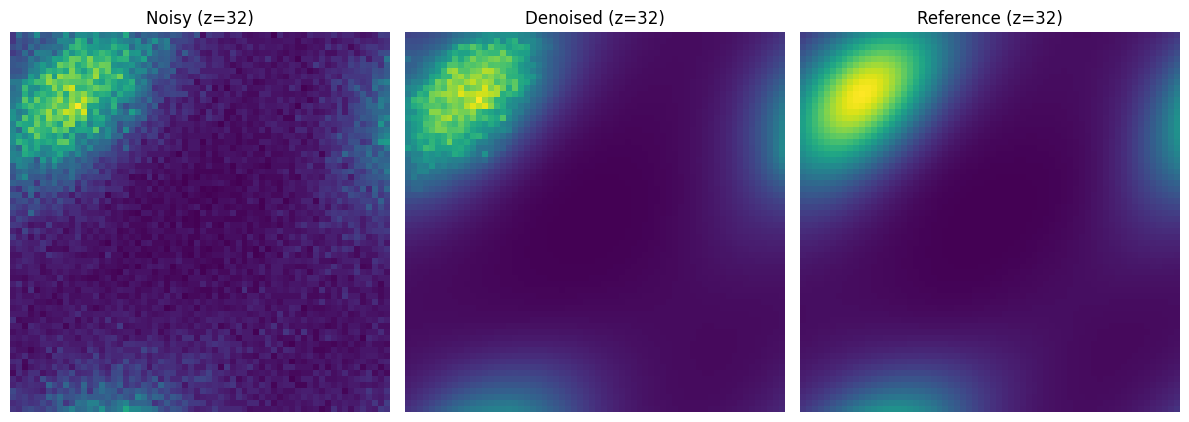

In [11]:
# Simulated test
np.random.seed(42)
scunet_pre_test_pipeline(test_d, ref_d)


In [13]:
############### scunet_Trained ###############

def scunet_trained_test_pipeline(test_d, ref_d):
    # Encode
    test_rgb = encode_voxel_to_rgb(test_d)
    ref_rgb  = encode_voxel_to_rgb(ref_d)

    # Denoise each of 64 RGB slices
    denoised_rgb = np.zeros_like(test_rgb)
    
    torch.serialization.add_safe_globals([SCUNet])

    model = torch.load('scunet_trained', weights_only=False)
    model.eval()
    def single2tensor4(img):
        """
        Convert HWC image [0,1] float32 to NCHW tensor
        """
        img_tensor = torch.from_numpy(np.transpose(img, (2, 0, 1))).float().unsqueeze(0)  # shape (1, 3, H, W)
        return img_tensor
    def tensor2single(tensor):
        """
        Convert NCHW or CHW tensor to HWC numpy array, clipped to [0,1]
        """
        tensor = tensor.squeeze().cpu().detach().numpy()
        if tensor.ndim == 3:
            img_np = np.transpose(tensor, (1, 2, 0))  # CHW -> HWC
        else:
            img_np = tensor  # in case it's grayscale
        return np.clip(img_np, 0, 1)


    def denoise_with_scunet(rgb_image_np, model, device='cuda'):
        """
        Denoise a single RGB image using SCUNet.
    
        Args:
            rgb_image_np: (H, W, 3), float32, values in [0,1]
            model: PyTorch SCUNet model
            device: 'cuda' or 'cpu'
    
        Returns:
            Denoised image (H, W, 3), float32 in [0,1]
        """
        img = rgb_image_np.astype(np.float32)
        
        # Ensure range is [0, 1]
        img = np.clip(img, 0, 1)
    
        img_tensor = single2tensor4(img).to(device)
    
        with torch.no_grad():
            output_tensor = model(img_tensor)
    
        output_np = tensor2single(output_tensor)
        return output_np

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    


    
    for i in range(test_rgb.shape[0]):
        noisy_slice = test_rgb[i]  # shape: (H, W, 3)
    
        denoised = denoise_with_scunet(noisy_slice, model, device=device)  # shape: (H, W, 3)
    
        if np.isnan(denoised).any():
            print(f"⚠️ NaNs detected in denoised slice {i}")
    
        denoised_rgb[i] = denoised



        

    ####

    # Reconstruct full 3D volume
    denoised_d = decode_rgb_to_voxel(denoised_rgb)

    # --- Evaluation ---
    print("\n>>> Evaluation Metrics")
    jsd_noisy = jensen_shannon_divergence_loss(
        tf.convert_to_tensor(test_d, dtype=tf.float32),
        tf.convert_to_tensor(ref_d, dtype=tf.float32)
    )
    jsd_denoised = jensen_shannon_divergence_loss(
        tf.convert_to_tensor(denoised_d, dtype=tf.float32),
        tf.convert_to_tensor(ref_d, dtype=tf.float32)
    )

    norm_noisy = np.linalg.norm(test_d - ref_d)
    norm_denoised = np.linalg.norm(denoised_d - ref_d)

    print(f"2-norm (noisy vs ref):     {norm_noisy:.4f}")
    print(f"2-norm (denoised vs ref): {norm_denoised:.4f}")
    print(f"JSD   (noisy vs ref):     {jsd_noisy.numpy():.6f}")
    print(f"JSD   (denoised vs ref):  {jsd_denoised.numpy():.6f}")

    # --- Plot example slices ---
    slice_idx = 32
    plt.figure(figsize=(12, 6))
    titles = ['Noisy', 'Denoised', 'Reference']
    data = [test_d[slice_idx], denoised_d[slice_idx], ref_d[slice_idx]]
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.imshow(data[i], cmap='viridis')
        plt.title(f"{titles[i]} (z={slice_idx})")
        plt.axis('off')
    plt.tight_layout()
    plt.show()



>>> Evaluation Metrics
2-norm (noisy vs ref):     0.0037
2-norm (denoised vs ref): 0.0026
JSD   (noisy vs ref):     0.008134
JSD   (denoised vs ref):  0.003605


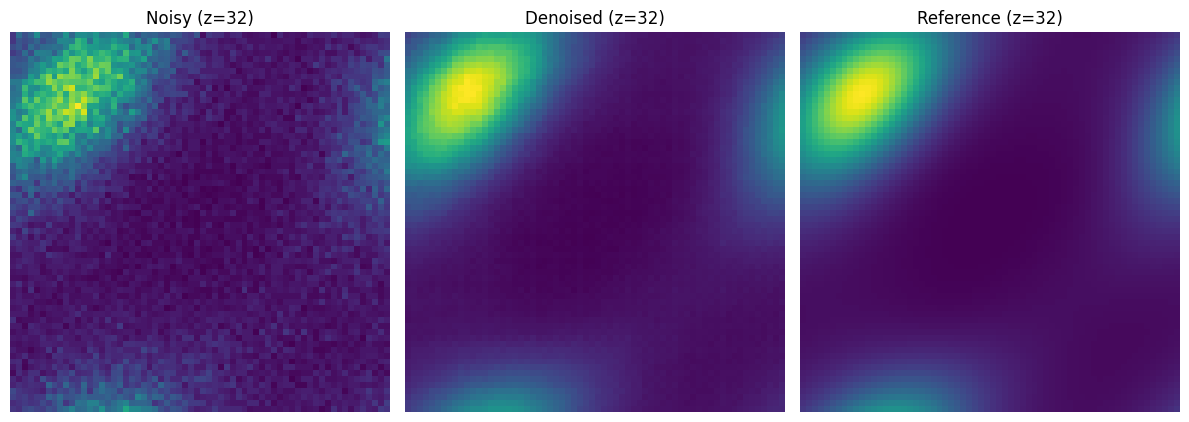

In [14]:

scunet_trained_test_pipeline(test_d, ref_d)

In [15]:
############## scunet_TL ##################


def scunet_FT_test_pipeline(test_d, ref_d):
    # Set device first
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Encode
    test_rgb = encode_voxel_to_rgb(test_d)
    ref_rgb  = encode_voxel_to_rgb(ref_d)

    # Denoise each of 64 RGB slices
    denoised_rgb = np.zeros_like(test_rgb)

    # Optional: only needed if loading full model with class definition
    torch.serialization.add_safe_globals([SCUNet])

    # Load model AFTER setting device
    model = torch.load('/pscratch/sd/k/kberard/SCGSR/3D_VMC/scunet_finetuned', map_location='cpu', weights_only=False)
    model.eval()

    def single2tensor4(img):
        """
        Convert HWC image [0,1] float32 to NCHW tensor
        """
        img_tensor = torch.from_numpy(np.transpose(img, (2, 0, 1))).float().unsqueeze(0)  # shape (1, 3, H, W)
        return img_tensor
    def tensor2single(tensor):
        """
        Convert NCHW or CHW tensor to HWC numpy array, clipped to [0,1]
        """
        tensor = tensor.squeeze().cpu().detach().numpy()
        if tensor.ndim == 3:
            img_np = np.transpose(tensor, (1, 2, 0))  # CHW -> HWC
        else:
            img_np = tensor  # in case it's grayscale
        return np.clip(img_np, 0, 1)


    def denoise_with_scunet(rgb_image_np, model, device='cuda'):
        """
        Denoise a single RGB image using SCUNet.
    
        Args:
            rgb_image_np: (H, W, 3), float32, values in [0,1]
            model: PyTorch SCUNet model
            device: 'cuda' or 'cpu'
    
        Returns:
            Denoised image (H, W, 3), float32 in [0,1]
        """
        img = rgb_image_np.astype(np.float32)
        
        # Ensure range is [0, 1]
        img = np.clip(img, 0, 1)
    
        img_tensor = single2tensor4(img).to(device)
    
        with torch.no_grad():
            output_tensor = model(img_tensor)
    
        output_np = tensor2single(output_tensor)
        return output_np

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    


    
    for i in range(test_rgb.shape[0]):
        noisy_slice = test_rgb[i]  # shape: (H, W, 3)
    
        denoised = denoise_with_scunet(noisy_slice, model, device=device)  # shape: (H, W, 3)
    
        if np.isnan(denoised).any():
            print(f"⚠️ NaNs detected in denoised slice {i}")
    
        denoised_rgb[i] = denoised



        

    ####

    # Reconstruct full 3D volume
    denoised_d = decode_rgb_to_voxel(denoised_rgb)

    # --- Evaluation ---
    print("\n>>> Evaluation Metrics")
    jsd_noisy = jensen_shannon_divergence_loss(
        tf.convert_to_tensor(test_d, dtype=tf.float32),
        tf.convert_to_tensor(ref_d, dtype=tf.float32)
    )
    jsd_denoised = jensen_shannon_divergence_loss(
        tf.convert_to_tensor(denoised_d, dtype=tf.float32),
        tf.convert_to_tensor(ref_d, dtype=tf.float32)
    )

    norm_noisy = np.linalg.norm(test_d - ref_d)
    norm_denoised = np.linalg.norm(denoised_d - ref_d)

    print(f"2-norm (noisy vs ref):     {norm_noisy:.4f}")
    print(f"2-norm (denoised vs ref): {norm_denoised:.4f}")
    print(f"JSD   (noisy vs ref):     {jsd_noisy.numpy():.6f}")
    print(f"JSD   (denoised vs ref):  {jsd_denoised.numpy():.6f}")

    # --- Plot example slices ---
    slice_idx = 32
    plt.figure(figsize=(12, 6))
    titles = ['Noisy', 'Denoised', 'Reference']
    data = [test_d[slice_idx], denoised_d[slice_idx], ref_d[slice_idx]]
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.imshow(data[i], cmap='viridis')
        plt.title(f"{titles[i]} (z={slice_idx})")
        plt.axis('off')
    plt.tight_layout()
    plt.show()



>>> Evaluation Metrics
2-norm (noisy vs ref):     0.0037
2-norm (denoised vs ref): 0.0024
JSD   (noisy vs ref):     0.008134
JSD   (denoised vs ref):  0.004003


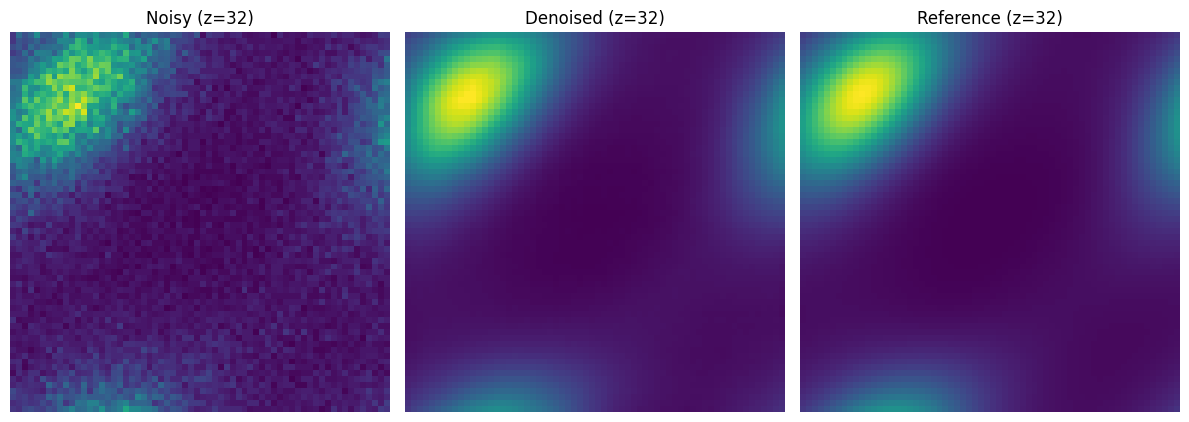

In [16]:

scunet_FT_test_pipeline(test_d, ref_d)

In [17]:
from keras.models import load_model
import keras

############# Nature #####################
import tensorflow as tf
@tf.keras.utils.register_keras_serializable()
class OnesLikeLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        return tf.ones_like(inputs)
def ones_like_fn(a):
    return tf.ones_like(a)
# Now load the model
nature_mod = tf.keras.models.load_model(
    "Nature.keras",
    custom_objects={'ones_like_fn': ones_like_fn}
)

from keras.layers import Lambda

layer = Lambda(lambda x: x, output_shape=(64, 64, 3))
def Nature_test_pipeline(test_d, ref_d):
    # Encode
    denoised_rgb = encode_voxel_to_rgb(test_d)
    ref_rgb  = encode_voxel_to_rgb(ref_d)
    print(denoised_rgb.shape,"x_test_shape")

    # Denoise each of 64 RGB slices
    #denoised_rgb = np.zeros_like(test_rgb)
    
    #denoised_rgb = nature_mod.predict(noisy_slice)  # shape: (H, W, 3)
    



    # Reconstruct full 3D volume
    denoised_d = decode_rgb_to_voxel(denoised_rgb)

    # --- Evaluation ---
    print("\n>>> Evaluation Metrics")
    jsd_noisy = jensen_shannon_divergence_loss(
        tf.convert_to_tensor(test_d, dtype=tf.float32),
        tf.convert_to_tensor(ref_d, dtype=tf.float32)
    )
    jsd_denoised = jensen_shannon_divergence_loss(
        tf.convert_to_tensor(denoised_d, dtype=tf.float32),
        tf.convert_to_tensor(ref_d, dtype=tf.float32)
    )

    norm_noisy = np.linalg.norm(test_d - ref_d)
    norm_denoised = np.linalg.norm(denoised_d - ref_d)

    print(f"2-norm (noisy vs ref):     {norm_noisy:.4f}")
    print(f"2-norm (denoised vs ref): {norm_denoised:.4f}")
    print(f"JSD   (noisy vs ref):     {jsd_noisy.numpy():.6f}")
    print(f"JSD   (denoised vs ref):  {jsd_denoised.numpy():.6f}")
    print(denoised_d.shape)

    # --- Plot example slices ---
    slice_idx = 32
    plt.figure(figsize=(12, 6))
    titles = ['Noisy', 'Denoised', 'Reference']
    data = [test_d[slice_idx], denoised_d[slice_idx], ref_d[slice_idx]]
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.imshow(data[i], cmap='viridis')
        plt.title(f"{titles[i]} (z={slice_idx})")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


(64, 64, 64, 3) x_test_shape

>>> Evaluation Metrics
2-norm (noisy vs ref):     0.0037
2-norm (denoised vs ref): 0.0052
JSD   (noisy vs ref):     0.008134
JSD   (denoised vs ref):  0.008113
(64, 64, 64)


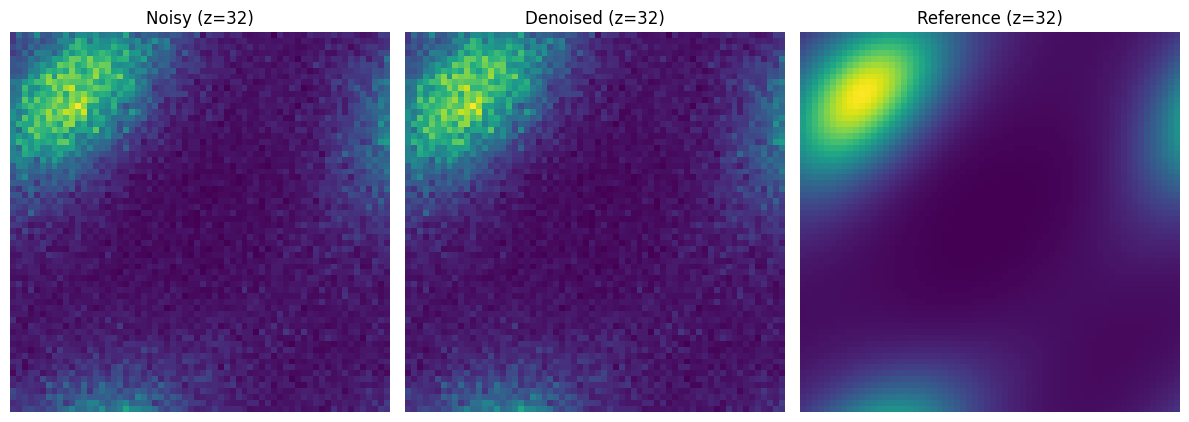

In [18]:
######## bug here !!!!!!!!!!!!!
Nature_test_pipeline(test_d, ref_d)

In [19]:
############### CAE_img_enc ###############
from keras.models import load_model
import keras
keras.config.enable_unsafe_deserialization()
CAE_mod = load_model('2d_CAE_IMG_enc.keras')
from keras.layers import Lambda

def CAE_test_pipeline(test_d, ref_d):
    # Encode
    test_rgb = encode_voxel_to_rgb(test_d)
    ref_rgb  = encode_voxel_to_rgb(ref_d)

    
    denoised_rgb = CAE_mod.predict(test_rgb)  # shape: (H, W, 3)
    



    # Reconstruct full 3D volume
    denoised_d = decode_rgb_to_voxel(denoised_rgb)

    # --- Evaluation ---
    print("\n>>> Evaluation Metrics")
    jsd_noisy = jensen_shannon_divergence_loss(
        tf.convert_to_tensor(test_d, dtype=tf.float32),
        tf.convert_to_tensor(ref_d, dtype=tf.float32)
    )
    jsd_denoised = jensen_shannon_divergence_loss(
        tf.convert_to_tensor(denoised_d, dtype=tf.float32),
        tf.convert_to_tensor(ref_d, dtype=tf.float32)
    )

    norm_noisy = np.linalg.norm(test_d - ref_d)
    norm_denoised = np.linalg.norm(denoised_d - ref_d)

    print(f"2-norm (noisy vs ref):     {norm_noisy:.4f}")
    print(f"2-norm (denoised vs ref): {norm_denoised:.4f}")
    print(f"JSD   (noisy vs ref):     {jsd_noisy.numpy():.6f}")
    print(f"JSD   (denoised vs ref):  {jsd_denoised.numpy():.6f}")

    # --- Plot example slices ---
    slice_idx = 32
    plt.figure(figsize=(12, 6))
    titles = ['Noisy', 'Denoised', 'Reference']
    data = [test_d[slice_idx], denoised_d[slice_idx], ref_d[slice_idx]]
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.imshow(data[i], cmap='viridis')
        plt.title(f"{titles[i]} (z={slice_idx})")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


I0000 00:00:1754431683.114065 1613034 service.cc:152] XLA service 0x7f1b98006d90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754431683.114092 1613034 service.cc:160]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
I0000 00:00:1754431683.114100 1613034 service.cc:160]   StreamExecutor device (1): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
I0000 00:00:1754431683.114103 1613034 service.cc:160]   StreamExecutor device (2): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
I0000 00:00:1754431683.114105 1613034 service.cc:160]   StreamExecutor device (3): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2025-08-05 15:08:03.131208: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1754431683.252005 1613034 cuda_dnn.cc:529] Loaded cuDNN version 90300


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step


I0000 00:00:1754431684.886624 1613034 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



>>> Evaluation Metrics
2-norm (noisy vs ref):     0.0037
2-norm (denoised vs ref): 0.0031
JSD   (noisy vs ref):     0.008134
JSD   (denoised vs ref):  0.003468


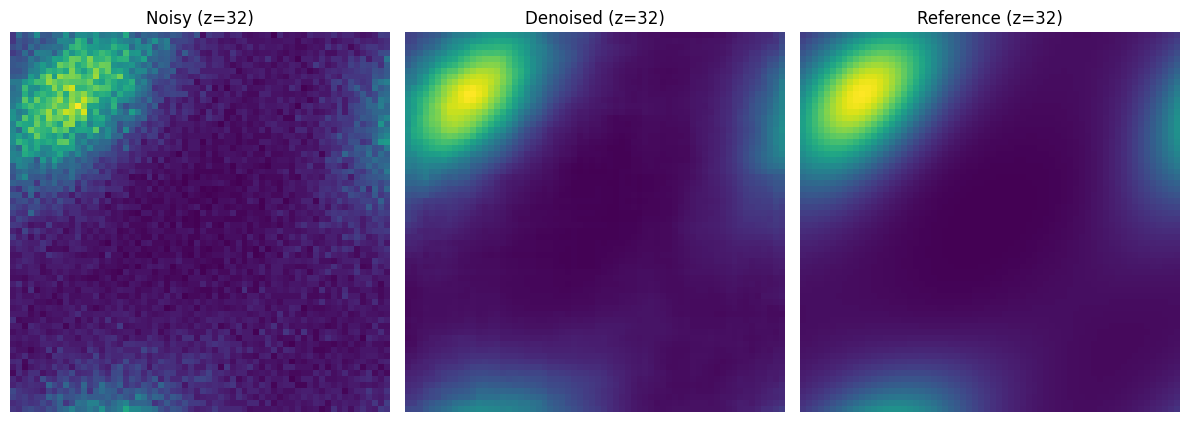

In [20]:

CAE_test_pipeline(test_d, ref_d)

In [21]:
# Fully working 

################# CAE_full_3D #############
from keras.models import load_model
import keras

############# Nature #####################
import tensorflow as tf

@tf.keras.utils.register_keras_serializable()
class RenormalizeToEight(tf.keras.layers.Layer):
    def call(self, x):
        total = tf.reduce_sum(x, axis=[1, 2, 3, 4], keepdims=True)
        return x / (total + 1e-8) * 8.0

@tf.keras.utils.register_keras_serializable()
def jensen_shannon_divergence_loss(y_true, y_pred):
    y_t = tf.cast(y_true, tf.float32)
    y_p = tf.cast(y_pred, tf.float32)

    y_t = tf.reshape(y_t, [tf.shape(y_t)[0], -1])
    y_p = tf.reshape(y_p, [tf.shape(y_p)[0], -1])

    y_t /= tf.reduce_sum(y_t, axis=1, keepdims=True) + 1e-8
    y_p /= tf.reduce_sum(y_p, axis=1, keepdims=True) + 1e-8

    m = 0.5 * (y_t + y_p)
    kl_true = tf.reduce_sum(y_t * tf.math.log((y_t + 1e-8) / (m + 1e-8)), axis=1)
    kl_pred = tf.reduce_sum(y_p * tf.math.log((y_p + 1e-8) / (m + 1e-8)), axis=1)
    return tf.reduce_mean(0.5 * (kl_true + kl_pred))



from keras.models import load_model
import keras
keras.config.enable_unsafe_deserialization()
CAE_3D_mod = tf.keras.models.load_model(
    "CAE_3D.keras",
    custom_objects={
        "RenormalizeToEight": RenormalizeToEight,
        "jensen_shannon_divergence_loss": jensen_shannon_divergence_loss
    }
)
from keras.layers import Lambda

def CAE_3D_test_pipeline(test_d, ref_d):
    # Encode
    test_rgb = test_d
    ref_rgb  = ref_d
    reshaped_arr = test_rgb.reshape(1,64, 64, 64, 1)
    
    denoised_rgb = CAE_3D_mod.predict(reshaped_arr)  # shape: (H, W, 3)
    



    # Reconstruct full 3D volume
    denoised_d = denoised_rgb.reshape(64,64,64)

    # --- Evaluation ---
    print("\n>>> Evaluation Metrics")
    jsd_noisy = jensen_shannon_divergence_loss(
        tf.convert_to_tensor(test_d, dtype=tf.float32),
        tf.convert_to_tensor(ref_d, dtype=tf.float32)
    )
    jsd_denoised = jensen_shannon_divergence_loss(
        tf.convert_to_tensor(denoised_d, dtype=tf.float32),
        tf.convert_to_tensor(ref_d, dtype=tf.float32)
    )

    norm_noisy = np.linalg.norm(test_d - ref_d)
    norm_denoised = np.linalg.norm(denoised_d - ref_d)

    print(f"2-norm (noisy vs ref):     {norm_noisy:.4f}")
    print(f"2-norm (denoised vs ref): {norm_denoised:.4f}")
    print(f"JSD   (noisy vs ref):     {jsd_noisy.numpy():.6f}")
    print(f"JSD   (denoised vs ref):  {jsd_denoised.numpy():.6f}")

    print(test_d.shape,denoised_d.shape,ref_d.shape)

    # --- Plot example slices ---
    slice_idx = 32
    plt.figure(figsize=(12, 6))
    titles = ['Noisy', 'Denoised', 'Reference']
    data = [test_d[slice_idx], denoised_d[slice_idx], ref_d[slice_idx]]
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.imshow(data[i], cmap='viridis')
        plt.title(f"{titles[i]} (z={slice_idx})")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

>>> Evaluation Metrics
2-norm (noisy vs ref):     0.0037
2-norm (denoised vs ref): 0.0002
JSD   (noisy vs ref):     0.000013
JSD   (denoised vs ref):  0.000000
(64, 64, 64) (64, 64, 64) (64, 64, 64)


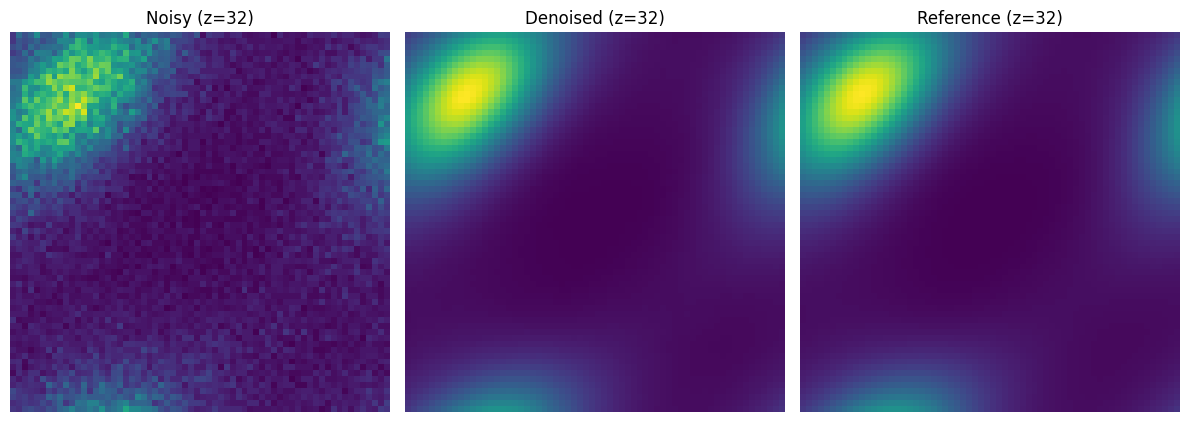

In [22]:
#bug herererere!!!!!!!!!!
CAE_3D_test_pipeline(test_d, ref_d)

In [23]:
from bm3d import bm3d
def bm3d_test_pipeline(test_d, ref_d):
    # Encode
    test_rgb = encode_voxel_to_rgb(test_d)
    ref_rgb  = encode_voxel_to_rgb(ref_d)

    # Denoise each of 64 RGB slices
    denoised_rgb = np.zeros_like(test_rgb)
    N = 100
    sigma = np.sqrt(1.0 / N)
    print("here")
    print(test_rgb.shape)



    #######
    for i in range(64):
        noisy_slice = test_rgb[i]

        gray_input = noisy_slice[:, :, 0]  # just one channel
        denoised_gray = bm3d(gray_input, sigma_psd=sigma)
        denoised_rgb[i] = np.stack([denoised_gray] * 3, axis=-1)

    ####

    # Reconstruct full 3D volume
    denoised_d = decode_rgb_to_voxel(denoised_rgb)

    # --- Evaluation ---
    print("\n>>> Evaluation Metrics")
    jsd_noisy = jensen_shannon_divergence_loss(
        tf.convert_to_tensor(test_d, dtype=tf.float32),
        tf.convert_to_tensor(ref_d, dtype=tf.float32)
    )
    jsd_denoised = jensen_shannon_divergence_loss(
        tf.convert_to_tensor(denoised_d, dtype=tf.float32),
        tf.convert_to_tensor(ref_d, dtype=tf.float32)
    )

    norm_noisy = np.linalg.norm(test_d - ref_d)
    norm_denoised = np.linalg.norm(denoised_d - ref_d)

    print(f"2-norm (noisy vs ref):     {norm_noisy:.4f}")
    print(f"2-norm (denoised vs ref): {norm_denoised:.4f}")
    print(f"JSD   (noisy vs ref):     {jsd_noisy.numpy():.6f}")
    print(f"JSD   (denoised vs ref):  {jsd_denoised.numpy():.6f}")

    # --- Plot example slices ---
    slice_idx = 32
    plt.figure(figsize=(12, 6))
    titles = ['Noisy', 'Denoised', 'Reference']
    data = [test_d[slice_idx], denoised_d[slice_idx], ref_d[slice_idx]]
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.imshow(data[i], cmap='viridis')
        plt.title(f"{titles[i]} (z={slice_idx})")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

here
(64, 64, 64, 3)

>>> Evaluation Metrics
2-norm (noisy vs ref):     0.0037
2-norm (denoised vs ref): 0.0045
JSD   (noisy vs ref):     0.000013
JSD   (denoised vs ref):  0.000012


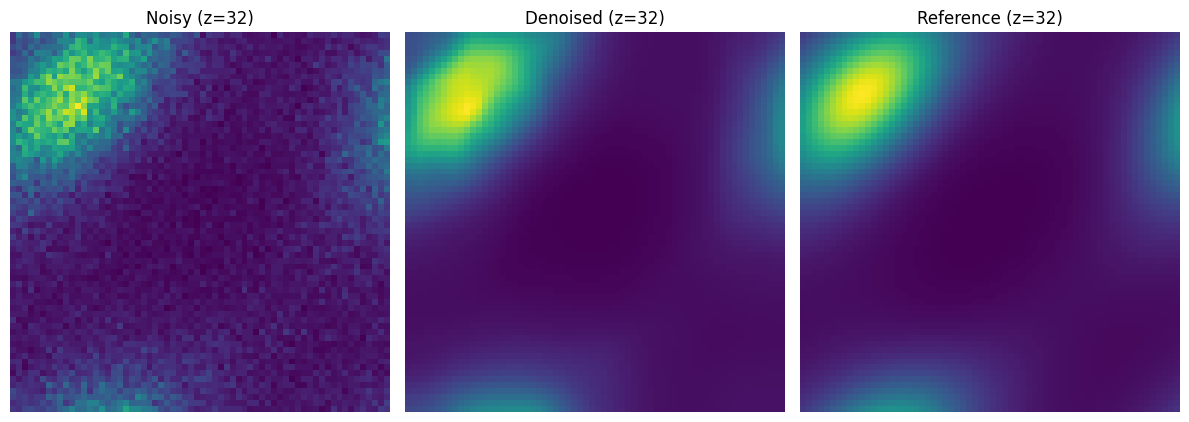

In [24]:
# Simulated test
np.random.seed(42)
bm3d_test_pipeline(test_d, ref_d)
